## TESTING TRACERS CODE:

1. Select a halo snapshot.
2. Compute Weigths with : st.weight_triaxial.
3. Compute Stellar properties. For densities purporses we need the masss.
4. Compute the density. Here we use the rho_enclosed function.

## To do:
## Check the values of the weights. 
## Check why the interpolation doesnt work for binsizes larger than 2.


In [1]:
%pylab inline
#import Stracers as st
import sys
sys.path.append('../MW_anisotropy/code/')
sys.path.append('../MW_anisotropy/code/densities/')
sys.path.append('./Stracers/')
from tracers_dens import *
#import density_tools
import reading_snapshots
from pygadgetreader import *
from smooth import savitzky_golay


from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline



Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [3]:
def rho_tracers(r, M, profile, profile_params):
    """
    Density profiles for the
    to-do:

    1. pass as an argument the density function instead of the if statements.
    2. profile paramas as *profile_params
    """
    if profile == 'Plummer':
        rho = dens_plummer(r, M, profile_params[0])
    elif profile == 'Hernquist':
        rho = dens_hernquist(r, M, profile_params[0])
    elif profile == 'NFW':
        rho = dens_NFWnRvir(r, M, profile_params[0], profile_params[1])
    elif profile == 'Einasto':
        rho = dens_Einasto(r, M, profile_params[0], profile_params[1])

    return rho


In [4]:
def rho_enclosed(r_posh, rmin, rmax, nbins, mass):
    r = np.linspace(rmin, rmax, nbins-1)
    rho = np.zeros(nbins-1)

    # Loop over the radial bins.
    for i in range(1, len(r)):
        indexh = np.where((r_posh<r[i]) & (r_posh>r[i-1]))[0]

        rho[i-1] = (3*(np.sum(mass[indexh]))) / (4*np.pi*(r[i]**3-r[i-1]**3))

    return r, rho

In [5]:
def all_host_particles(xyz, vxyz, pids, pot, mass, N_host_particles):
    """
    Function that return the host and the sat particles
    positions and velocities.

    Parameters:
    -----------
    xyz: snapshot coordinates with shape (n,3)
    vxys: snapshot velocities with shape (n,3)
    pids: particles ids
    Nhost_particles: Number of host particles in the snapshot
    Returns:
    --------
    xyz_mw, vxyz_mw, xyzlmc, vxyz_lmc: coordinates and velocities of
    the host and the sat.

    """
    sort_indexes = np.sort(pids)
    N_cut = sort_indexes[N_host_particles]
    host_ids = np.where(pids<N_cut)[0]
    return xyz[host_ids], vxyz[host_ids], pids[host_ids], pot[host_ids], mass[host_ids]

In [25]:
def energies(r_part, Ep, v, n_rbins, n_ebins, m):
    r"""
    
    Parameters:
    -----------
    
    r_part: 'numpy.array`
        Galactocentric distances of the DM particles in [$kpc$].
    pmass: float
        Mass of a DM particle in units of solar masses.
    Ep : 'numpy.array`
        potential energy in units of
    v : 'numpy.array`
        velocities in km/s
    n_rbins : int
        number of bins, this will be used to bin the potential energy.
    
    Returns:
    --------
    
    $\Psi$ : $\Psi = -\Phi + \Phi_0$ Relative potential. 
    $\epsilon$ : $\epsilon = -E + \phi_0$ relative total energy.
    
    
    """

    G = 4.30071e-6 # Gadget units
    nbins_coarsed = 20
    E_k = 0.5*m*v**2 # Kinetic energy / mass.
    E = E_k + Ep
    epsilon = (-1.0)*E

    # Binning the data in logarithmic bins in radius
    # Should I need to worried about centering the bin?
    # yes if you are going to interpolate.

    rbins = np.logspace(np.min(np.log10(r_part)), np.max(np.log10(r_part)), nbins_coarsed)
    # spaced between rbins
    dr = np.zeros(len(rbins)-1)
    for i in range(len(rbins)-1):
        dr[i] = rbins[i+1] - rbins[i]

    pot = np.zeros(nbins_coarsed-1)

    for i in range(len(rbins)-1):
        index_bins = np.where((r_part<rbins[i+1])
                              & (r_part>=rbins[i]))[0]

        if len(index_bins) == 0:
            pot[i] = 0
            print('Warning : No particles found at r={:0>2f} kpc'.format(rbins[i]))
        else:
            pot[i] = np.mean(Ep[index_bins])


    f_interp_pot = interp1d(rbins[:-1]+dr, pot, kind='cubic')
    r_interp = np.linspace(rbins[0]+dr[0], rbins[-2]+dr[-2], n_rbins)
    pot_interp = f_interp_pot(r_interp)
    psi = (-1.0)*pot_interp



    #Binning Energy for g(E) and f(E) (f(epsilon)) calculations
    Histo_E, Edges = np.histogram(E, bins=n_ebins)
    Histo_epsilon, epsedges = np.histogram(epsilon, bins=n_ebins)

    # Are these always positive?
    dE = Edges[1]-Edges[0]
    depsilon = epsedges[1]-epsedges[0]

    Edges = Edges + dE/2.
    epsedges = epsedges + depsilon/2.


    return r_interp, psi, epsilon, Histo_epsilon

In [15]:
def densities_derivatives(rbins, psi_bins, interp_bins=100, profile='Hernquist'):
    """
    Computes the derivatives of 
    
    rbins : number of radial bins.
    
    psi_bins : psi binned.
    
    inter_bins : int
        Values of the interpolated 
    
    
    """
    spl1 = InterpolatedUnivariateSpline(rbins, psi_bins)

    # interpolating in the radial bins.  
    rbins_hr = np.linspace(min(rbins), max(rbins), interp_bins)
    #nu_tracer_hr = spl1(rbins_hr)
    nu_tracer=rho_tracers(rbins_hr, 1, profile, [10])
    psi_hr = spl1(rbins_hr)


    # First derivative.
    dnu_dpsi = np.gradient(nu_tracer, psi_hr)
    #spl3 = interp1d(rbins, dnu_dpsi, kind='cubic')
    #dnu_dpsi_hr = spl3(rbins_hr)

    # second derivative
    #dnu2_dpsi2 = np.gradient(dnu_dpsi, psi2)
    
    # smoothing first derivative
    #dnu_dpsi_smooth = savitzky_golay(dnu_dpsi, 5, 3)
    dnu2_dpsi2 = np.gradient(dnu_dpsi, psi_hr)
    # smoothing second derivative
    #dnu2_dpsi2_smooth = savitzky_golay(dnu2_dpsi2, 5, 3)

    return rbins_hr, nu_tracer, psi_hr, dnu_dpsi, dnu2_dpsi2

In [16]:
def distribution_function(psi, dnu2_dpsi2, epsilon):
    
    assert len(epsilon)<len(psi), 'Hey'
    
    factor = 1/(np.sqrt(8)*np.pi**2)
    dpsi = psi[2]-psi[1]
    df = np.zeros(len(epsilon))
    
    for i in range(len(epsilon)):
        index = np.where(psi<=epsilon[i])[0]
        df[i] = np.sum(dpsi/(np.sqrt(epsilon[i] - psi[index])) * dnu2_dpsi2[index])
    return factor*df
    
    

In [17]:
snapshot = './halos/LMC1_97K_vir_000'


pp = readsnap(snapshot, 'pos', 'dm')
vv = readsnap(snapshot, 'vel', 'dm')
mass = readsnap(snapshot, 'mass', 'dm')
Epp = readsnap(snapshot, 'pot', 'dm')
ids = readsnap(snapshot, 'pid', 'dm')


r = np.sqrt(pp[:,0]**2+pp[:,1]**2+pp[:,2]**2)

# truncating the halo

r_cut = index = np.where(r<100)[0]

pp = pp[r_cut]
r = r[r_cut]
vv = vv[r_cut]
mass = mass[r_cut]
Epp = Epp[r_cut]
ids = ids[r_cut]

v = np.sqrt(vv[:,0]**2 + vv[:,1]**2 + vv[:,2]**2)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [28]:
rbins, psi, epsilon, Histo_epsilon = energies(r, Epp*mass[0]*1E10, v, 100, 100, mass[0]*1E10)

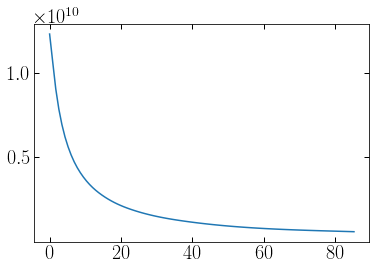

In [29]:
plot(rbins, psi)

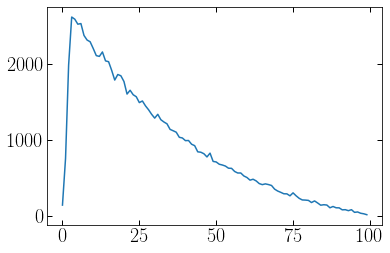

In [31]:
plot(Histo_epsilon)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


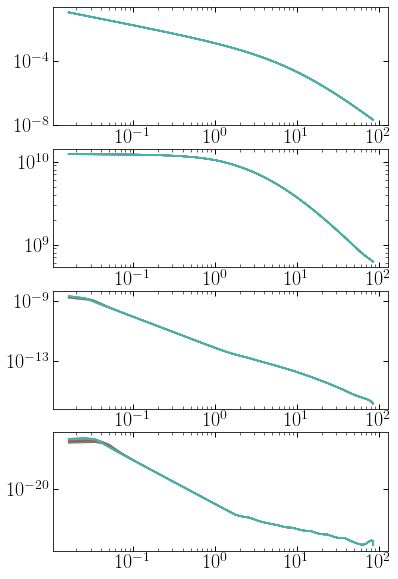

In [21]:
figure(figsize=(6, 10))

for i in range(5000, 10000, 500):
    r_hr, nu_tracer, psi_hr, dnu_dpsi_smooth, dnu2_dpsi2_smooth = densities_derivatives(rbins, 
                                                                                        psi, 
                                                                                        interp_bins=i,
                                                                                        profile='Hernquist')
    subplot(4, 1, 1)
    loglog(r_hr, nu_tracer)

    subplot(4, 1, 2)
    loglog(r_hr, psi_hr)

    subplot(4, 1, 3)
    loglog(r_hr, dnu_dpsi_smooth)

    subplot(4, 1, 4)
    loglog(r_hr, dnu2_dpsi2_smooth)



In [22]:
df = distribution_function(psi_hr, dnu2_dpsi2_smooth, Histo_epsilon)

In [23]:
sort_energies = argsort(Histo_epsilon)

/usr/local/lib/python3.5/dist-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


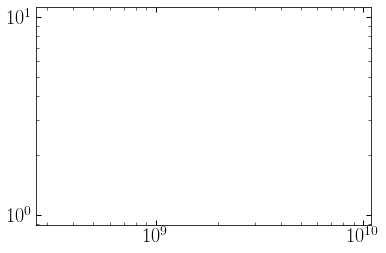

In [24]:
plt.loglog(epsilon[sort_energies], (df[sort_energies])*(4.30071e-6*mass[0]*1E10*10)**(3/2.))

In [34]:
df[1]

0.0